<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

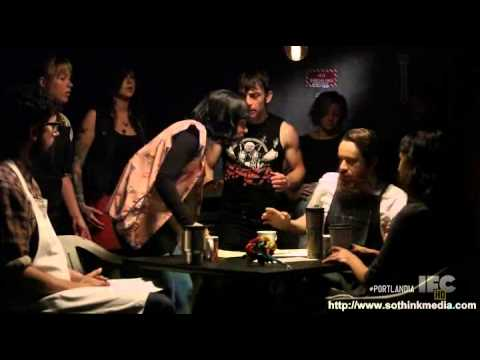

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [3]:
%pwd

'/home/andronik/repos/Unit4/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


# 1. Exploratory Data Analysis

In [5]:
# Start here 
# How many coffee shops? 79
shops['coffee_shop_name'].value_counts()

Epoch Coffee                            400
Halcyon                                 300
The Factory - Cafe With a Soul          244
Houndstooth Coffee                      200
Venezia Italian Gelato                  200
                                       ... 
Lucky Lab Coffee                         25
Sister Coffee                            17
Kowabunga Coffee                         16
The Marvelous Vintage Tea Party Co.      10
Lola Savannah Coffee Downtown             4
Name: coffee_shop_name, Length: 79, dtype: int64

In [6]:
# shape of df
shops.shape

(7616, 3)

In [7]:
# ~70% of the coffee shops are good.
# what are their similaries via reviews
shops['star_rating'].value_counts(normalize=True)[:50]

 5.0 star rating     0.496324
 4.0 star rating     0.309874
 3.0 star rating     0.096901
 2.0 star rating     0.060399
 1.0 star rating     0.036502
Name: star_rating, dtype: float64

In [8]:
# isolating the reviews and making the text lowercase
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: x.lower())
shops['full_review_text'].value_counts().head(1)

 11/9/2016 1 check-in listed in in search of fantastic coffee so, i really didn't want to write this review. i didn't want to tell anyone how awesome the factory - cafe with a soul is because i don't want it overrun and super busy with no place to sit like so many other decent coffee shops in austin. i happened to come in here with a friend mid-week and we sat here for several hours, enjoying the peace and quiet, the atmosphere, and the awesome coffee.  this place is a little eclectic - lots of peculiar art, books, games, knick-knacks, and an almost head-scratching drink and food menu. waffles and pop tarts...and beer? and... coffee mojitos? well, it works. whatever is going on here, it works fabulously. they serve stumptown coffee, which as someone from the northwest, i totally appreciate. they also brew coffee correctly. there is not a hint of bitterness or overcooked milk going on here. the ipad ordering screens are mostly cool, (although they need more options for customization) an

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [9]:
# taking a sample review for some exploration
sample = shops['full_review_text'][0]
sample

' 11/25/2016 1 check-in love love loved the atmosphere! every corner of the coffee shop had its own style, and there were swings!!! i ordered the matcha latte, and it was muy fantastico! ordering and getting my drink were pretty streamlined. i ordered on an ipad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. i got my latte within minutes!  i was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. any ideas? '

In [10]:
# using the regular expressions package
# this keeps lowercases letters, spaces and numbers.
import re

re.sub(r'[^a-zA-Z ^0-9]', ' ', sample)

' 11 25 2016 1 check in love love loved the atmosphere  every corner of the coffee shop had its own style  and there were swings    i ordered the matcha latte  and it was muy fantastico  ordering and getting my drink were pretty streamlined  i ordered on an ipad  which included all beverage selections that ranged from coffee to wine  desired level of sweetness  and a checkout system  i got my latte within minutes   i was hoping for a typical heart or feather on my latte  but found myself listing out all the possibilities of what the art may be  any ideas  '

In [11]:
def tokenize(text):
    """
    Parses a string into a list of sematic units(words)
    """
    tokens = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = tokens.lower().split()

    return tokens

In [12]:
tokenize(sample)

['check',
 'in',
 'love',
 'love',
 'loved',
 'the',
 'atmosphere',
 'every',
 'corner',
 'of',
 'the',
 'coffee',
 'shop',
 'had',
 'its',
 'own',
 'style',
 'and',
 'there',
 'were',
 'swings',
 'i',
 'ordered',
 'the',
 'matcha',
 'latte',
 'and',
 'it',
 'was',
 'muy',
 'fantastico',
 'ordering',
 'and',
 'getting',
 'my',
 'drink',
 'were',
 'pretty',
 'streamlined',
 'i',
 'ordered',
 'on',
 'an',
 'ipad',
 'which',
 'included',
 'all',
 'beverage',
 'selections',
 'that',
 'ranged',
 'from',
 'coffee',
 'to',
 'wine',
 'desired',
 'level',
 'of',
 'sweetness',
 'and',
 'a',
 'checkout',
 'system',
 'i',
 'got',
 'my',
 'latte',
 'within',
 'minutes',
 'i',
 'was',
 'hoping',
 'for',
 'a',
 'typical',
 'heart',
 'or',
 'feather',
 'on',
 'my',
 'latte',
 'but',
 'found',
 'myself',
 'listing',
 'out',
 'all',
 'the',
 'possibilities',
 'of',
 'what',
 'the',
 'art',
 'may',
 'be',
 'any',
 'ideas']

In [13]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [14]:
# import head
shops.head(2)

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 listed in date night: austin, ambia...",4.0 star rating


In [15]:
# inspect shape (again)
shops.shape

(7616, 3)

In [16]:
shops['tokens'] = shops['full_review_text'].apply(tokenize) 

In [17]:
shops['tokens'].head()

0    [check, in, love, love, loved, the, atmosphere...
1    [listed, in, date, night, austin, ambiance, in...
2    [check, in, listed, in, brunch, spots, i, love...
3    [very, cool, decor, good, drinks, nice, seatin...
4    [check, in, they, are, located, within, the, n...
Name: tokens, dtype: object

## 2. Analysis of tokens

In [18]:
# Importing a new library to figure out the most common words
from collections import Counter

word_counts = Counter()

shops['tokens'].apply(lambda x: word_counts.update(x))

word_counts.most_common(10)

[('the', 34909),
 ('and', 26774),
 ('i', 24630),
 ('a', 22857),
 ('to', 17345),
 ('it', 12693),
 ('of', 12638),
 ('is', 12004),
 ('in', 11609),
 ('coffee', 10572)]

In [19]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [20]:
# Use the Function
wc = count(shops['tokens'])

In [21]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
52,the,6854,34909,1.0,0.044008,0.044008,0.899947
6,and,6869,26774,2.0,0.033753,0.077761,0.901917
41,i,5877,24630,3.0,0.031050,0.108810,0.771665
58,a,6250,22857,4.0,0.028815,0.137625,0.820641
0,to,5676,17345,5.0,0.021866,0.159491,0.745273


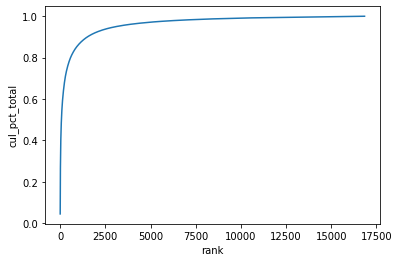

In [22]:
import seaborn as sns

# Cumulative distribution plot
# What does this show? - Pareto principle.
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

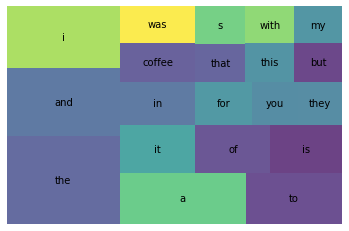

In [23]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 3. Processing Raw Text with Spacy

In [24]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [25]:
# Print out list of tokens
[token.text for token in tokenizer(sample)]

[' ',
 '11/25/2016',
 '1',
 'check-in',
 'love',
 'love',
 'loved',
 'the',
 'atmosphere!',
 'every',
 'corner',
 'of',
 'the',
 'coffee',
 'shop',
 'had',
 'its',
 'own',
 'style,',
 'and',
 'there',
 'were',
 'swings!!!',
 'i',
 'ordered',
 'the',
 'matcha',
 'latte,',
 'and',
 'it',
 'was',
 'muy',
 'fantastico!',
 'ordering',
 'and',
 'getting',
 'my',
 'drink',
 'were',
 'pretty',
 'streamlined.',
 'i',
 'ordered',
 'on',
 'an',
 'ipad,',
 'which',
 'included',
 'all',
 'beverage',
 'selections',
 'that',
 'ranged',
 'from',
 'coffee',
 'to',
 'wine,',
 'desired',
 'level',
 'of',
 'sweetness,',
 'and',
 'a',
 'checkout',
 'system.',
 'i',
 'got',
 'my',
 'latte',
 'within',
 'minutes!',
 ' ',
 'i',
 'was',
 'hoping',
 'for',
 'a',
 'typical',
 'heart',
 'or',
 'feather',
 'on',
 'my',
 'latte,',
 'but',
 'found',
 'myself',
 'listing',
 'out',
 'all',
 'the',
 'possibilities',
 'of',
 'what',
 'the',
 'art',
 'may',
 'be.',
 'any',
 'ideas?']

In [31]:
# Tokenizer Pipe

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [32]:
shops['tokens'].head()

0    [ , 11/25/2016, 1, check-in, love, love, loved...
1    [ , 12/2/2016, listed, in, date, night:, austi...
2    [ , 11/30/2016, 1, check-in, listed, in, brunc...
3    [ , 11/25/2016, very, cool, decor!, good, drin...
4    [ , 12/3/2016, 1, check-in, they, are, located...
Name: tokens, dtype: object

In [33]:
wc = count(shops['tokens'])

In [34]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
55,the,6847,34649,1.0,0.042825,0.042825,0.899028
6,and,6853,26442,2.0,0.032681,0.075506,0.899816
61,a,6240,22657,3.0,0.028003,0.103509,0.819328
54,,7616,22606,4.0,0.027940,0.131449,1.000000
42,i,5511,19990,5.0,0.024707,0.156156,0.723608


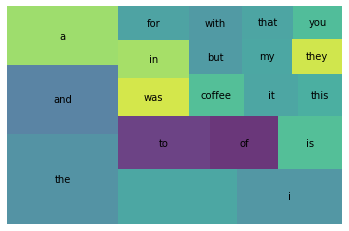

In [35]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 4. Updating tokens without stopwords.

In [36]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [37]:
shops.tokens.head()

0    [ , 11/25/2016, 1, check-in, love, love, loved...
1    [ , 12/2/2016, listed, date, night:, austin,, ...
2    [ , 11/30/2016, 1, check-in, listed, brunch, s...
3    [ , 11/25/2016, cool, decor!, good, drinks, ni...
4    [ , 12/3/2016, 1, check-in, located, northcros...
Name: tokens, dtype: object

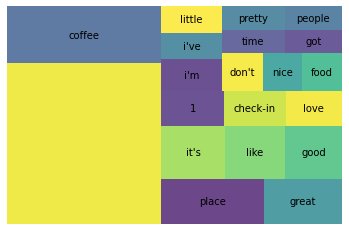

In [38]:
wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5. Extending stopword and making it fit to your specific data.

In [39]:
print(type(nlp.Defaults.stop_words))

<class 'set'>


In [64]:
STOP_WORDS = nlp.Defaults.stop_words.union([' ','I', 'i', "don't", 'it', "it's", 'it.', 'the', 'this','1', '-', "i'm", "i've", "good", "got", "like", 'coffee', 'place', 'great', 'try', 'time','come','go'])

In [65]:
STOP_WORDS

{' ',
 "'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 '-',
 '1',
 'I',
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'coffee',
 'come',
 'could',
 'did',
 'do',
 'does',
 'doing',
 "don't",
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'fo

In [66]:
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [67]:
wc = count(shops['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
13,check-in,1957,1961,1.0,0.005382,0.005382,0.256959
33,love,1434,1806,2.0,0.004956,0.010338,0.188288
788,little,1230,1479,3.0,0.004059,0.014397,0.161502
184,nice,1188,1368,4.0,0.003754,0.018151,0.155987
432,food,1092,1363,5.0,0.003741,0.021892,0.143382


## 6. Modified treemap with extended stopwords.

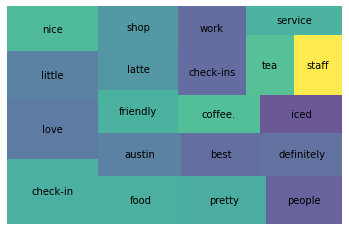

In [68]:
wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 7. Lemmatization

In [69]:
# Wrap it all in a function
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
                lemmas.append(token.lemma_)
    
    return lemmas

In [70]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

In [71]:
shops['lemmas'].head()

0    [11/25/2016, check, love, love, love, atmosphe...
1    [12/2/2016, list, date, night, austin, ambianc...
2    [11/30/2016, check, list, brunch, spot, love, ...
3    [11/25/2016, cool, decor, drink, nice, seating...
4    [12/3/2016, check, locate, northcross, mall, s...
Name: lemmas, dtype: object

## 8. Lemmatized with extended stopword

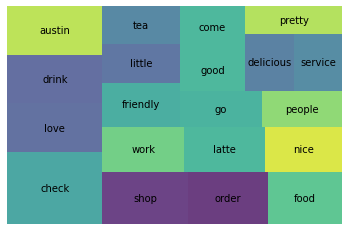

In [72]:
wc = count(shops['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [73]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,tokens,lemmas
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in love love loved the atm...,5.0 star rating,"[11/25/2016, check-in, love, love, loved, atmo...","[11/25/2016, check, love, love, love, atmosphe..."
1,The Factory - Cafe With a Soul,"12/2/2016 listed in date night: austin, ambia...",4.0 star rating,"[12/2/2016, listed, date, night:, austin,, amb...","[12/2/2016, list, date, night, austin, ambianc..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in listed in brunch spots ...,4.0 star rating,"[11/30/2016, check-in, listed, brunch, spots, ...","[11/30/2016, check, list, brunch, spot, love, ..."
3,The Factory - Cafe With a Soul,11/25/2016 very cool decor! good drinks nice ...,2.0 star rating,"[11/25/2016, cool, decor!, drinks, nice, seati...","[11/25/2016, cool, decor, drink, nice, seating..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in they are located within ...,4.0 star rating,"[12/3/2016, check-in, located, northcross, mal...","[12/3/2016, check, locate, northcross, mall, s..."


## 9. Layer in star ratings.

In [74]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,tokens,lemmas
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in love love loved the atm...,5.0 star rating,"[11/25/2016, check-in, love, love, loved, atmo...","[11/25/2016, check, love, love, love, atmosphe..."
1,The Factory - Cafe With a Soul,"12/2/2016 listed in date night: austin, ambia...",4.0 star rating,"[12/2/2016, listed, date, night:, austin,, amb...","[12/2/2016, list, date, night, austin, ambianc..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in listed in brunch spots ...,4.0 star rating,"[11/30/2016, check-in, listed, brunch, spots, ...","[11/30/2016, check, list, brunch, spot, love, ..."
3,The Factory - Cafe With a Soul,11/25/2016 very cool decor! good drinks nice ...,2.0 star rating,"[11/25/2016, cool, decor!, drinks, nice, seati...","[11/25/2016, cool, decor, drink, nice, seating..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in they are located within ...,4.0 star rating,"[12/3/2016, check-in, located, northcross, mal...","[12/3/2016, check, locate, northcross, mall, s..."


In [75]:
shops['star_rating'].value_counts()

5.0 star rating    3780
4.0 star rating    2360
3.0 star rating     738
2.0 star rating     460
1.0 star rating     278
Name: star_rating, dtype: int64

In [76]:
shops['star_rating'] = shops['star_rating'].apply(lambda x: x.strip())

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?
Couple of Notes
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences

## 9a. Good Coffee Shops

In [77]:
import nltk

In [78]:
good = shops[(shops['star_rating']=='5.0 star rating') | (shops['star_rating']=='4.0 star rating')]

In [79]:
good.head()

,coffee_shop_name,full_review_text,star_rating,tokens,lemmas
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in love love loved the atm...,5.0 star rating,"[11/25/2016, check-in, love, love, loved, atmo...","[11/25/2016, check, love, love, love, atmosphe..."
1,The Factory - Cafe With a Soul,"12/2/2016 listed in date night: austin, ambia...",4.0 star rating,"[12/2/2016, listed, date, night:, austin,, amb...","[12/2/2016, list, date, night, austin, ambianc..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in listed in brunch spots ...,4.0 star rating,"[11/30/2016, check-in, listed, brunch, spots, ...","[11/30/2016, check, list, brunch, spot, love, ..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in they are located within ...,4.0 star rating,"[12/3/2016, check-in, located, northcross, mal...","[12/3/2016, check, locate, northcross, mall, s..."
5,The Factory - Cafe With a Soul,11/20/2016 1 check-in very cute cafe! i think...,4.0 star rating,"[11/20/2016, check-in, cute, cafe!, think, mom...","[11/20/2016, check, cute, cafe, think, moment,..."


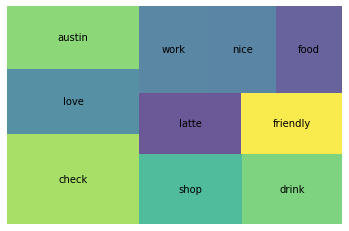

In [80]:
wc = count(good['lemmas'])
wc_top20 = wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 9b. Bad Coffee Shops

In [81]:
bad = shops[(shops['star_rating']=='3.0 star rating') | (shops['star_rating']=='2.0 star rating') | (shops['star_rating']=='1.0 star rating')]

In [82]:
bad.shape

(1476, 5)

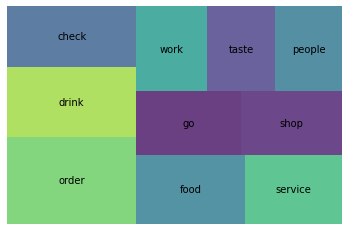

In [83]:
wc = count(bad['lemmas'])
wc_top20 = wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 10. Summary Report

Good Coffee shops
- great food and drinks with a friendly atmosphere.

Bad Coffee shops
- Check might of took some time
- service was not so great
- food might of not been so good.


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

